In [1]:
import tensorflow as tf
from keras import layers, models, applications, optimizers, callbacks
import tensorflow_addons as tfa
import os
import json
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def parse_tfrecord(example):
    # Define the feature description
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string, default_value='jpeg'),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }

    # Parse the input tf.Example proto using the dictionary above
    parsed = tf.io.parse_single_example(example, feature_description)

    # Decode the image
    image = tf.io.decode_jpeg(parsed['image/encoded'], channels=3)
    IMAGE_SIZE = (224, 224)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # Normalize to [0,1]

    # Extract bounding box coordinates and labels
    xmin = tf.sparse.to_dense(parsed['image/object/bbox/xmin'], default_value=0.0)
    xmax = tf.sparse.to_dense(parsed['image/object/bbox/xmax'], default_value=0.0)
    ymin = tf.sparse.to_dense(parsed['image/object/bbox/ymin'], default_value=0.0)
    ymax = tf.sparse.to_dense(parsed['image/object/bbox/ymax'], default_value=0.0)
    labels = tf.sparse.to_dense(parsed['image/object/class/label'], default_value=-1)

    # Check if bounding box or label arrays are empty
    if tf.size(xmin) == 0 or tf.size(labels) == 0:
        bbox = tf.constant([0.0, 0.0, 0.0, 0.0])  # Default bbox for empty images
        label = tf.constant(-1)  # Default label for missing objects
    else:
        # For simplicity, assume single object per image
        bbox = tf.stack([xmin[0], ymin[0], xmax[0], ymax[0]], axis=-1)  # [xmin, ymin, xmax, ymax]
        label = labels[0] - 1  # Adjust if labels start at 1

    return image, bbox


In [11]:
if __name__ == '__main__':
    # Set constants    
    EPOCHS = 25    

    # Paths to your dataset folders
    TRAIN_TFRECORD = 'D:/Onedrive/experiments/experiments/Objectron/bounding_box_regression/apple_dataset/train/Apple.tfrecord'
    VALID_TFRECORD = 'D:/Onedrive/experiments/experiments/Objectron/bounding_box_regression/apple_dataset/valid/Apple.tfrecord'
    TEST_TFRECORD = 'D:/Onedrive/experiments/experiments/Objectron/bounding_box_regression/apple_dataset/test/Apple.tfrecord'
    LABEL_MAP_PATH = 'D:/Onedrive/experiments/experiments/Objectron/bounding_box_regression/apple_dataset/train/Apple_label_map.pbtxt'  # Adjust if labels are elsewhere

    # Create datasets
    train_ds = get_dataset(TRAIN_TFRECORD, is_training=True)
    valid_ds = get_dataset(VALID_TFRECORD, is_training=False)
    test_ds = get_dataset(TEST_TFRECORD, is_training=False)

    # Load label map (if multiple classes exist)
    label_map = parse_label_map(LABEL_MAP_PATH)
    num_classes = len(label_map)
    print(f"Number of classes: {num_classes}")
    print(f"Label Map: {label_map}")

    model = create_model(num_classes)
    model.summary()

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='mse',  # Mean Squared Error for bounding box regression
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

Number of classes: 0
Label Map: {}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)   

In [12]:
# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint("apple_bbox_regression_model.h5", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [13]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/25
7/7 [==============================] - 19s 3s/step - loss: 1.0677 - mean_absolute_error: 0.8135 - val_loss: 0.0682 - val_mean_absolute_error: 0.2039
Epoch 2/25
7/7 [==============================] - 22s 3s/step - loss: 0.5334 - mean_absolute_error: 0.5786 - val_loss: 0.0492 - val_mean_absolute_error: 0.1703
Epoch 3/25
7/7 [==============================] - 28s 4s/step - loss: 0.2905 - mean_absolute_error: 0.4227 - val_loss: 0.0318 - val_mean_absolute_error: 0.1345
Epoch 4/25
7/7 [==============================] - 27s 4s/step - loss: 0.1714 - mean_absolute_error: 0.3268 - val_loss: 0.0341 - val_mean_absolute_error: 0.1458
Epoch 5/25
7/7 [==============================] - 31s 4s/step - loss: 0.1279 - mean_absolute_error: 0.2876 - val_loss: 0.0232 - val_mean_absolute_error: 0.1136
Epoch 6/25
7/7 [==============================] - 28s 4s/step - loss: 0.0969 - mean_absolute_error: 0.2473 - val_loss: 0.0343 - val_mean_absolute_error: 0.1431
Epoch 7/25
7/7 [========================

In [7]:
# Evaluate the model
test_loss, test_mae = model.evaluate(test_ds)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

3/3 [==============================] - 5s 1s/step - loss: 0.0092 - mean_absolute_error: 0.0762
Test Loss (MSE): 0.009243056178092957
Test MAE: 0.07623130828142166


In [8]:
# Function to visualize predictions
def visualize_predictions(model, dataset, num_samples=5):
    IMAGE_SIZE = (224, 224)
    import matplotlib.patches as patches
    for images, bboxes in dataset.take(1):
        predictions = model.predict(images)
        for i in range(min(num_samples, images.shape[0])):
            img = images[i].numpy()
            true_bbox = bboxes[i].numpy()
            pred_bbox = predictions[i]
            
            # Convert normalized coordinates back to image size if needed
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            
            # True bounding box in red
            rect = patches.Rectangle(
                (true_bbox[0]*IMAGE_SIZE[1], true_bbox[1]*IMAGE_SIZE[0]),
                (true_bbox[2]-true_bbox[0])*IMAGE_SIZE[1],
                (true_bbox[3]-true_bbox[1])*IMAGE_SIZE[0],
                linewidth=2, edgecolor='r', facecolor='none', label='True BBox'
            )
            ax.add_patch(rect)
            
            # Predicted bounding box in green
            rect = patches.Rectangle(
                (pred_bbox[0]*IMAGE_SIZE[1], pred_bbox[1]*IMAGE_SIZE[0]),
                (pred_bbox[2]-pred_bbox[0])*IMAGE_SIZE[1],
                (pred_bbox[3]-pred_bbox[1])*IMAGE_SIZE[0],
                linewidth=2, edgecolor='g', facecolor='none', label='Predicted BBox'
            )
            ax.add_patch(rect)
            
            plt.legend(handles=[
                patches.Patch(color='red', label='True BBox'),
                patches.Patch(color='green', label='Predicted BBox')
            ])
            plt.show()


1/1 [==============================] - 3s 3s/step


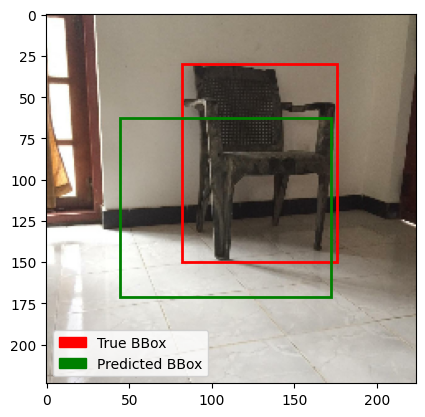

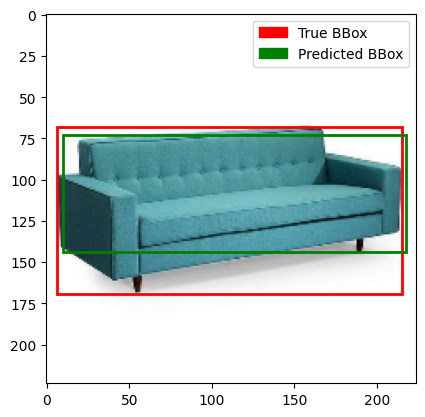

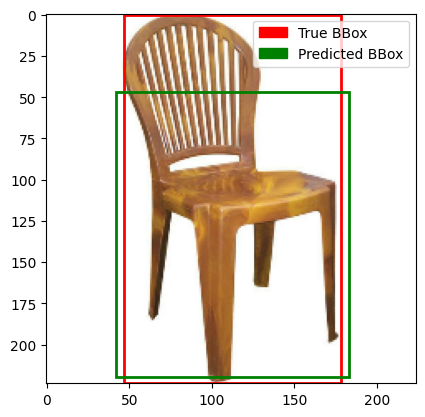

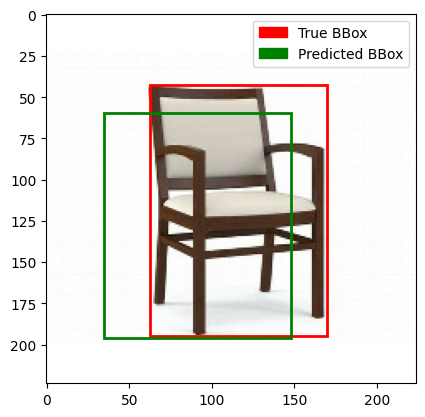

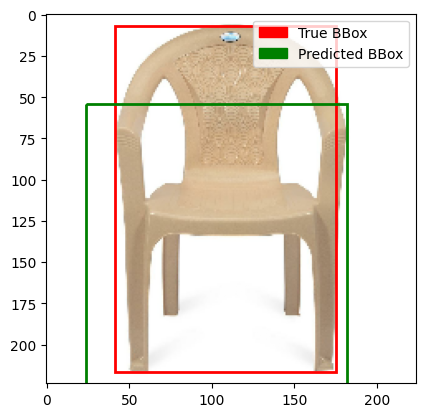

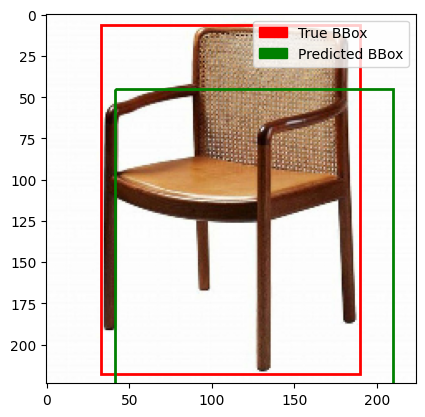

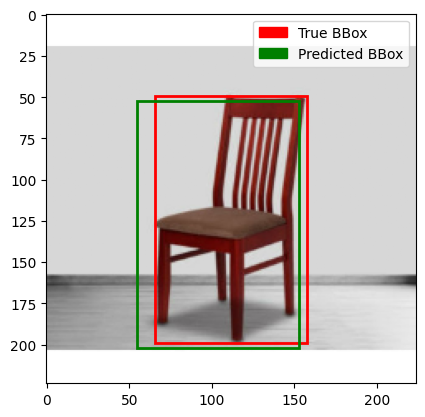

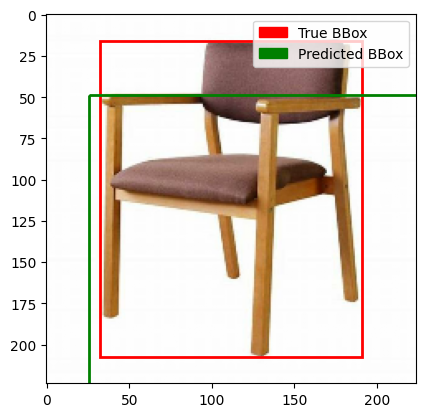

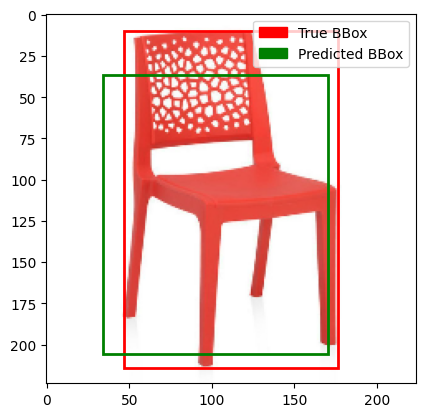

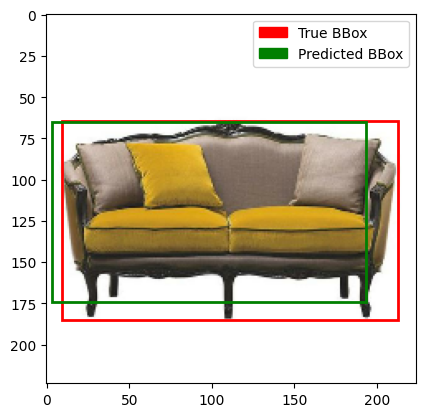

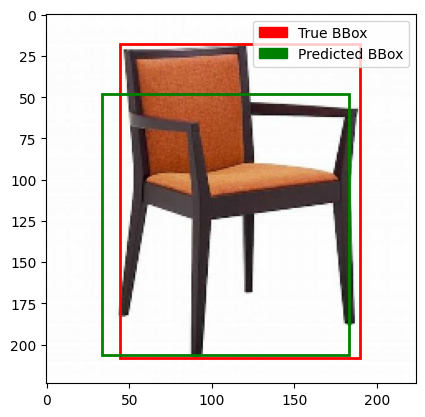

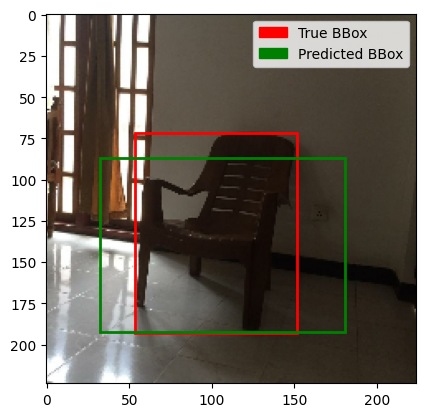

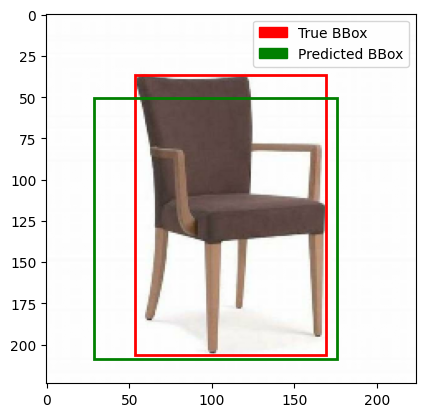

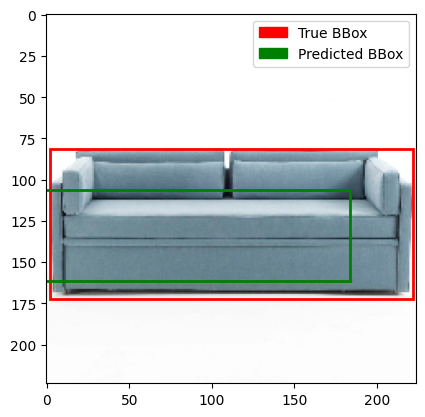

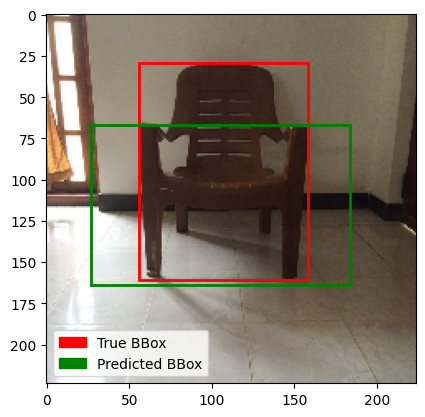

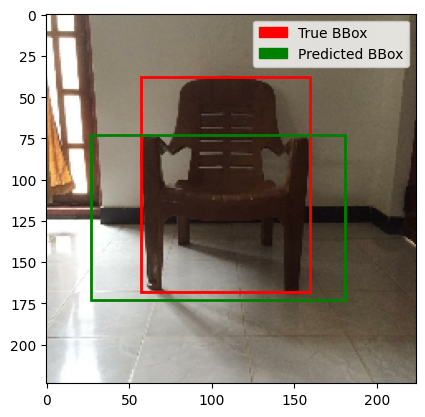

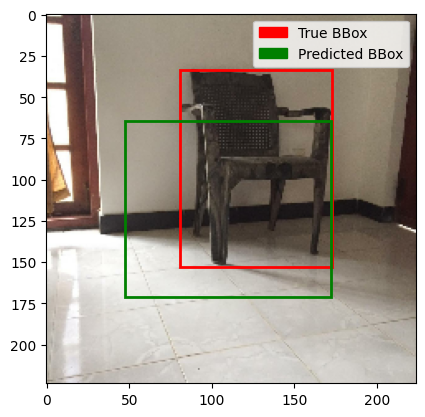

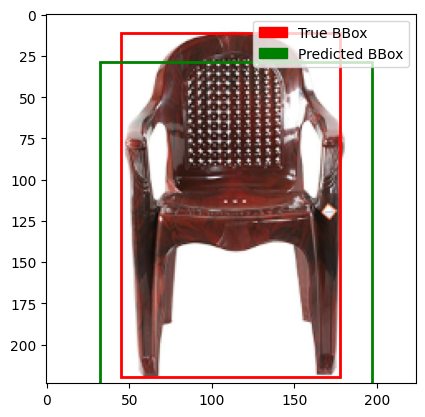

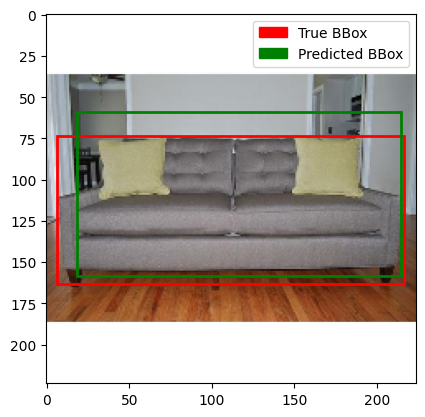

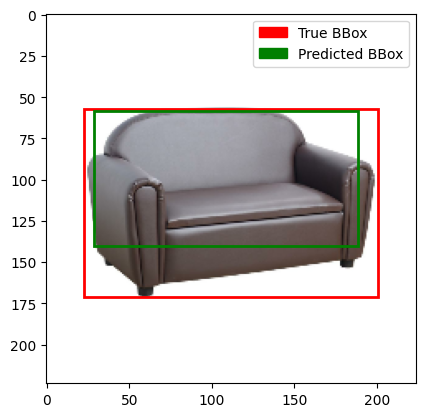

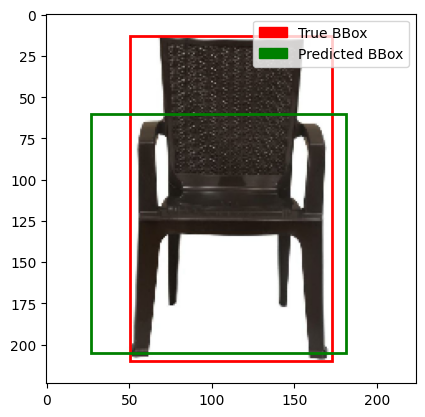

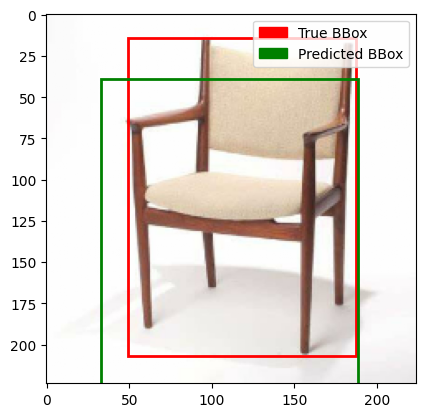

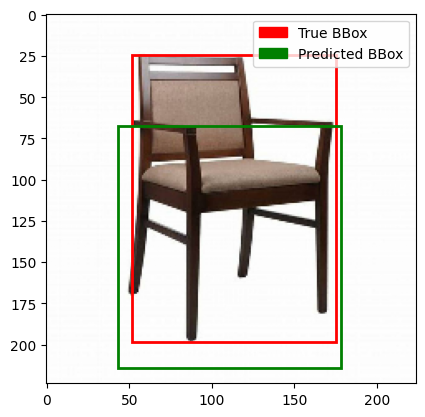

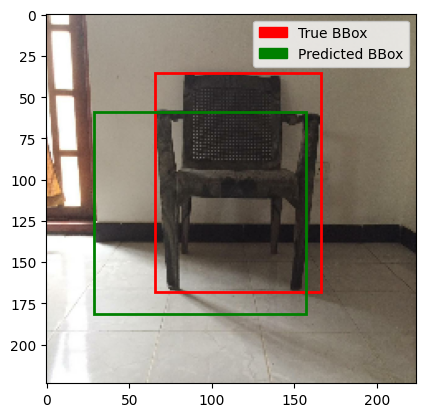

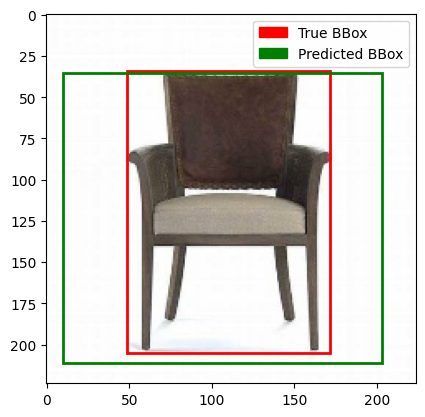

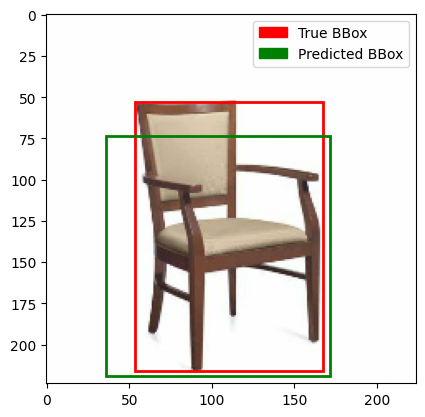

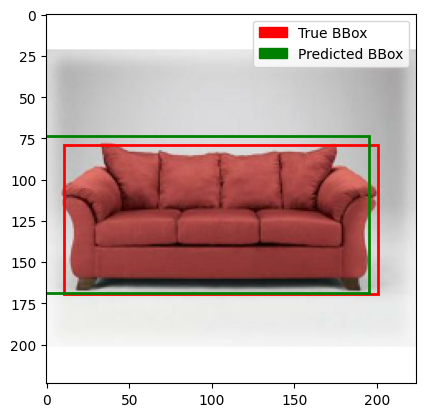

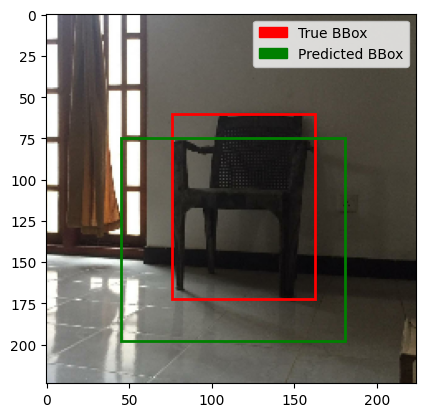

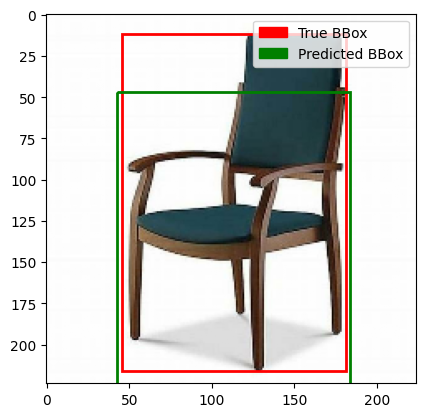

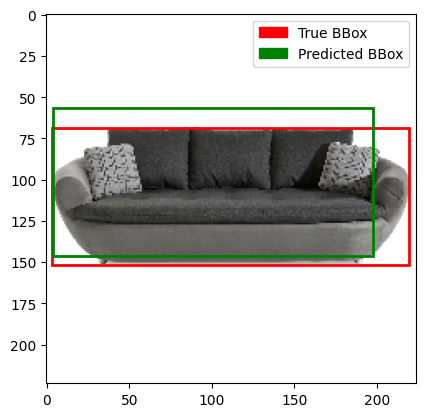

In [10]:
# Visualize some predictions
visualize_predictions(model, test_ds, num_samples=30)